In [2]:
%load_ext autoreload

In [104]:
%autoreload 2 
import sys
import os
import glob
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm
import colormaps

from CAP.caliop import CALIOP
from CAP.visualization import plot_caliop_curtain
from contrails.satellites.goes.reprojection import get_reprojection_path
from contrails.satellites.goes.abi import ash_from_nc, ORTHO_EXTENT, ORTHO_PROJ

plt.rc("font", family="serif")

In [125]:
L1_root = "/net/d15/data/vmeijer/CALIOP_L1/"
L2_root = "/net/d13/data/vmeijer/data/CALIPSO/CALIOP_L2/"
ca1 = CALIOP(os.path.join(L1_root, "CAL_LID_L1-Standard-V4-10.2018-08-08T18-58-40ZD_Subset.hdf"))
ca2_5000 = CALIOP(os.path.join(L2_root, "CAL_LID_L2_05kmCLay-Standard-V4-20.2018-08-08T18-58-40ZD_Subset.hdf"))


Load L2 collocation result

In [108]:
df = pd.read_parquet(("../scripts/"
           "CAL_LID_L2_05kmCLay-Standard-V4-20.2018-08-08T18-58-40ZD_Subset_L2_collocation.parquet"))

df = df[np.abs((df['caliop_time'] - df['adv_time']) / np.timedelta64(1, 's')) < 120]

df["segment_number"] = df.groupby("segment_start_lat").ngroup()

sub = df[df.segment_number == 1]

Load ash image

In [111]:
nc_path = get_reprojection_path(dt.datetime(2018, 8, 8, 19, 25), product="ABI-L2-MCMIPC")
ash = ash_from_nc(xr.open_dataset(nc_path)).reshape((2000, 3000, 3))

Get L1 data corresponding to L2 data segment.

In [114]:
lats = ca2_5000.get("Latitude")[:,0]
lons = ca2_5000.get("Longitude")[:,0]

extent = [sub.caliop_lon.min(), sub.caliop_lon.max(), sub.caliop_lat.min(), sub.caliop_lat.max()]

locs = np.abs(ca2_5000.get("Latitude")[:,1][:,np.newaxis] - sub.caliop_lat.values[np.newaxis,:]).argmin(axis=0)

start_pids = ca2_5000.get("Profile_ID")[locs,0]
end_pids = ca2_5000.get("Profile_ID")[locs,1]
layer_tops = ca2_5000.get("Layer_Top_Altitude")[locs,0]
layer_bots = ca2_5000.get("Layer_Base_Altitude")[locs, 0]

correction_pid = ca1.get("Profile_ID")[np.abs(ca1.get("Latitude")[:,0] - extent[2]).argmin(), 0]


cloud_mask, b532, b1064, lons, lats, times = ca1.get_cloud_mask(extent=extent,
                                                                   return_backscatters=True,
                                                                  ve1=8, ve2=15)

data = (cloud_mask * b532)

In [123]:
cmap, norm, _ = ca1.get_backscatter_cmap()

Do actual plotting

/home/vmeijer/.conda/envs/gspy/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/vmeijer/.conda/envs/gspy/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(95, 14.5, '30 km')

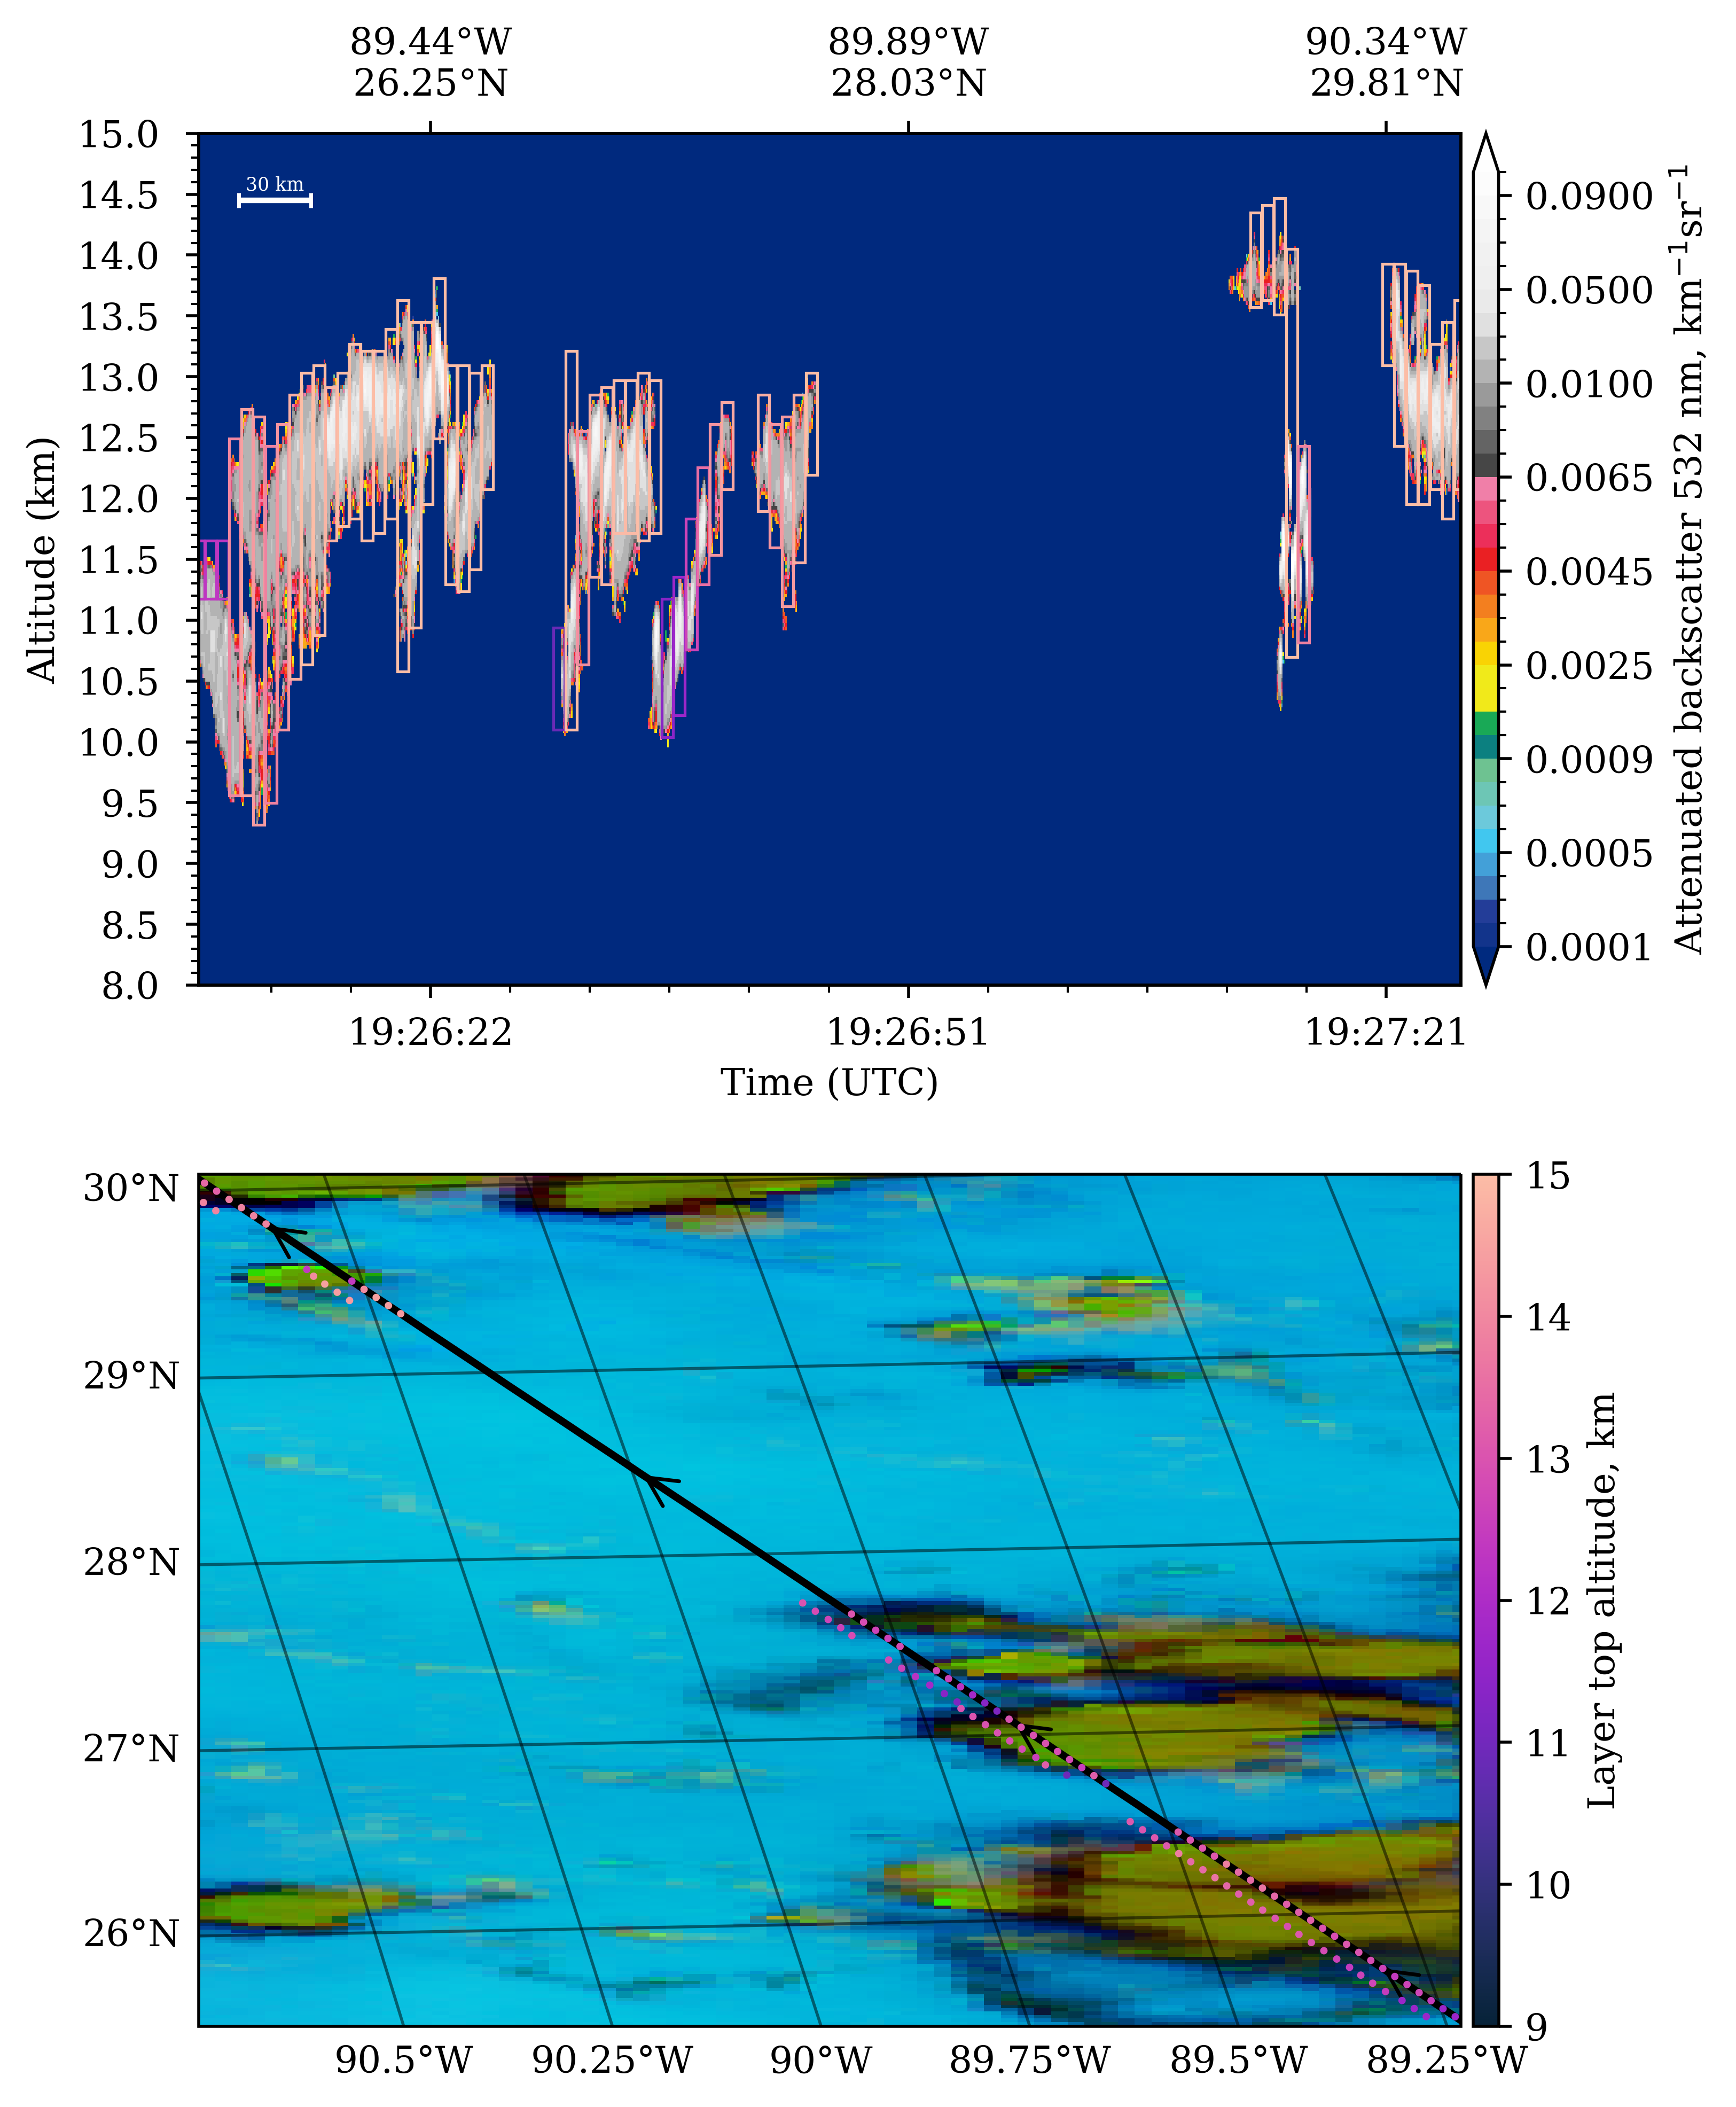

In [124]:
fig = plt.figure(dpi=500, figsize=(4.72441, 1.5*4.72441))


ax = fig.add_axes([0, 0.55, 1, 0.45])

plot_caliop_curtain(fig, ax, lons, lats, times, data,
                          min_alt=8, max_alt=15)

# Plot L2 layers
for (s, e, t, b) in zip(start_pids, end_pids, layer_tops, layer_bots):
    
    ec = colormaps.bubblegum( (t - 10)/3)
    ax.add_patch(mpatches.Rectangle([s-correction_pid, b], width=e-s, height=t-b, facecolor="none",
                                    edgecolor=ec, linewidth=0.75))


ax.tick_params(axis="y", direction="out", which="both")
ax.set_ylim(8, 15)
ax.set_xlim(0,data.shape[1])



    
gax = fig.add_axes([0, 0, 1, 0.45], projection=ORTHO_PROJ)

gax.imshow(ash, extent=ORTHO_EXTENT, origin='upper', transform=ORTHO_PROJ)

gax.set_extent([extent[0], extent[1], extent[2]+0.1, extent[3]-0.1], ccrs.PlateCarree())
gax.set_aspect('auto')
gl = gax.gridlines(draw_labels=True, color='k', alpha=0.5)
gl.xlabels_top = False
gl.ylabels_right = False 

gax.plot(lons, lats, transform=ccrs.PlateCarree(), c="k", linewidth=2, label="CALIPSO ground track", zorder=3,
        )

transform = ccrs.Geodetic()._as_mpl_transform(gax)
for pp in np.linspace(100, data.shape[1]-100, 4):
    
    pp = int(pp)
    gax.annotate("",xytext=(lons[pp],lats[pp]), xy=(lons[pp+5], lats[pp+5]), arrowprops=dict(arrowstyle="->",
                                                                                           color="k"),
               size=20, xycoords=transform)


# Plot collocated profile positions
gax.scatter(sub.caliop_lon.values, sub.caliop_lat.values,
            c=sub.caliop_top_height.values/1000, transform=ccrs.PlateCarree(),s=1,
              zorder=3, cmap=colormaps.bubblegum, vmin=9, vmax=15)

# Plot collocated pixel positions
cf = gax.scatter(sub.caliop_lon_adv_parallax.values, sub.caliop_lat_adv_parallax.values,
           c=sub.caliop_top_height.values/1000, transform=ccrs.PlateCarree(),s=1,
          zorder=3, cmap=colormaps.bubblegum, vmin=9, vmax=15)


pos = gax.get_position()
cax = fig.add_axes([pos.x1+0.01, pos.y0 , 0.02, pos.y1-pos.y0])
cbar = plt.colorbar(cf, cax=cax, label="Layer top altitude, km")

pos = ax.get_position()
cax = fig.add_axes([pos.x1+0.01, pos.y0 , 0.02, pos.y1-pos.y0])

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax,
             label=r"Attenuated backscatter 532 nm, km${}^{-1}$sr${}^{-1}$", extend="both")


ax.errorbar(95, 14.45, xerr=45, c="w", capsize=2.0)
ax.annotate("30 km", (95, 14.5), ha="center", va="bottom", c="w", size=5)

#plt.savefig("fig01.png", dpi=500, bbox_inches="tight")
